# This notebook explores the census tract food access data and compares it to community area adult obesity rates #

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import cleantools as ct

In [2]:
food_data = pd.read_csv('./data/food_data.csv')
obesity_rate_df = pd.read_csv('./data/chicago_health_atlas_adult_obesity_rate.csv')
census_to_community = pd.read_csv('./data/chicago_census_tract_to_community_area.csv')

In [3]:
food_data.shape

(1314, 160)

In [4]:
obesity_rate_df.shape

(75, 5)

In [5]:
census_to_community.shape

(794, 3)

### Cleaning obesity data and merging with table containing census tract and community area conversion ###

In [6]:
obesity_rate_df.isna().sum()

Layer                   1
Name                    1
GEOID                   1
HCSOBP_2016-2018        0
HCSOBP_2016-2018_moe    0
dtype: int64

In [7]:
obesity_rate_df.head()

,Layer,Name,GEOID,HCSOBP_2016-2018,HCSOBP_2016-2018_moe
0,NaN,NaN,NaN,"Adult obesity rate (% of adults), 2016-2018",(90% margin of error)
1,Community area,Rogers Park,1.0,33.5,6.33660714232
2,Community area,Norwood Park,10.0,27.9,8.35089285674
3,Community area,Jefferson Park,11.0,20.8,7.721428571395
4,Community area,Forest Glen,12.0,20.3,12.841071428605


The reason the obesity rate data has nulls is because some of the header took two rows.  Let's drop that extra row.

In [8]:
obesity_rate_df.drop(0, inplace=True)

In [9]:
obesity_rate_df.dtypes

Layer                    object
Name                     object
GEOID                   float64
HCSOBP_2016-2018         object
HCSOBP_2016-2018_moe     object
dtype: object

In [10]:
def float_to_int(num):
    return int(num)

obesity_rate_df['GEOID'] = obesity_rate_df['GEOID'].apply(float_to_int)

In [11]:
# Convert the rows that should be numeric but were not coded as such because of the extra header to float.
obesity_rate_df['HCSOBP_2016-2018'] = obesity_rate_df['HCSOBP_2016-2018'].apply(ct.convert_to_float)
obesity_rate_df['HCSOBP_2016-2018_moe'] = obesity_rate_df['HCSOBP_2016-2018_moe'].apply(ct.convert_to_float)

In [12]:
obesity_rate_df['GEOID'].max()

77

In [13]:
census_to_community['Community Area'].max()

77

It looks like GEOID in the health data corresponds with community area in the census to community conversion table.  Both contain values up to 77. However, this data source does not appear to include every census tract that is in food_data.csv.

In [14]:
obesity_rate_df.columns

Index(['Layer', 'Name', 'GEOID', 'HCSOBP_2016-2018', 'HCSOBP_2016-2018_moe'], dtype='object')

Merging the obesity rate data with the census to community conversion table so each census tract will also be labeled with the community area it is in.

In [15]:
census_to_community.columns

Index(['Tract', 'Label', 'Community Area'], dtype='object')

In [16]:
census_to_community.isna().sum()

Tract             0
Label             0
Community Area    0
dtype: int64

In [17]:
census_to_community.dtypes

Tract              int64
Label             object
Community Area     int64
dtype: object

In [18]:
obesity_rate_df.columns

Index(['Layer', 'Name', 'GEOID', 'HCSOBP_2016-2018', 'HCSOBP_2016-2018_moe'], dtype='object')

In [19]:
obesity_rate_df.isna().sum()

Layer                   0
Name                    0
GEOID                   0
HCSOBP_2016-2018        0
HCSOBP_2016-2018_moe    0
dtype: int64

In [20]:
obesity_rate_df.rename({'GEOID': 'Community Area'}, axis=1, inplace=True)

In [21]:
obesity_rate_by_census_df = pd.merge(left=census_to_community, right=obesity_rate_df, how='left', on='Community Area')

In [22]:
obesity_rate_by_census_df.isna().sum()

Tract                   0
Label                   0
Community Area          0
Layer                   8
Name                    8
HCSOBP_2016-2018        8
HCSOBP_2016-2018_moe    8
dtype: int64

Some rows are null after merging.  What happened?

In [23]:
obesity_rate_by_census_df[obesity_rate_by_census_df['HCSOBP_2016-2018'].isna()]

,Tract,Label,Community Area,Layer,Name,HCSOBP_2016-2018,HCSOBP_2016-2018_moe
391,17031340300,"Census Tract 3403, Cook County, Illinois",34,NaN,NaN,NaN,NaN
392,17031340400,"Census Tract 3404, Cook County, Illinois",34,NaN,NaN,NaN,NaN
393,17031340500,"Census Tract 3405, Cook County, Illinois",34,NaN,NaN,NaN,NaN
394,17031340600,"Census Tract 3406, Cook County, Illinois",34,NaN,NaN,NaN,NaN
475,17031470100,"Census Tract 4701, Cook County, Illinois",47,NaN,NaN,NaN,NaN
723,17031835500,"Census Tract 8355, Cook County, Illinois",37,NaN,NaN,NaN,NaN
724,17031835600,"Census Tract 8356, Cook County, Illinois",37,NaN,NaN,NaN,NaN
766,17031841100,"Census Tract 8411, Cook County, Illinois",34,NaN,NaN,NaN,NaN


It appears that community areas 34, 37, and 47 were not included in the obesity data.  These will need to be dropped.

In [24]:
obesity_rate_by_census_df.dropna(inplace=True)

### Beginning EDA on the food access data. ###

In [25]:
# Custom function creates a dataframe with information about the NULLs and datatypes of each column.
food_info = ct.info_frame(food_data)

In [26]:
food_info.sort_values(by='num_nans', ascending=False).head()

,name,type,num_nans
133,lahunv20share,float64,1314
94,lablack10,float64,1314
106,lahunv10,float64,1314
105,lahisp10share,float64,1314
103,laomultir10share,float64,1314


In [27]:
len(food_info[food_info['num_nans'] == 1314])

52

In [28]:
len(food_info[food_info['num_nans'] == 0])

49

This data has quite a few NULL values.  These values are actually coded as NULL in the original csv, suggeting that they are missing information or irrelevant for the selected census tract.  52 of the 160 columns are entirely NULL.  A total of 49 columns in this table have no NULL values at all.

In [29]:
null_cols = [food_info.loc[col]['name'] for col in food_info.index if food_info.loc[col]['num_nans'] == 1314]

In [30]:
# Drop the columns that have only NULL values, as well as Unnamed: 0
food_data.drop(columns=null_cols, inplace=True)
food_data.drop(columns='Unnamed: 0', inplace=True)

In [31]:
food_data.shape

(1314, 107)

In [32]:
food_info = ct.info_frame(food_data)

In [33]:
food_info.sort_values(by='num_nans', ascending=False).head()

,name,type,num_nans
30,LALOWI1_20,float64,974
28,LALOWI1_10,float64,974
27,LAPOP1_20,float64,974
25,LAPOP1_10,float64,974
81,lasnap1,float64,972


In [34]:
food_data['LAPOP05_10'].value_counts()

0.0       48
3.0        4
1.0        4
4.0        4
2186.0     3
          ..
3149.0     1
2424.0     1
57.0       1
2985.0     1
1101.0     1
Name: LAPOP05_10, Length: 799, dtype: int64

At least some columns with NULL values also have some 0 values, so it's reasonable to assume that NULL does not mean 0.  It's also reasonable to assume that it doesn't indicate the feature is somehow irrelevant for a given census tract, as these correspond to values such as the portion of low-access, low-income population at certain distances from a supermarket.  Since no further information is provided about these NULL values, it seems most likely that the data was not available.

Since NULL values will be problematic for any method of food desert identification, and we want to include every census tract in our analysis, let's examine the features that have no NULL values at all.  These features alone may provide enough information for our analysis.

To get some idea of whether the features without NULL values can sufficiently identify food deserts, let's do a very quick and basic regression.  We will see whether these features have the potential to predict adult obesity rate, which we expect to be higher in food deserts.

In [35]:
food_non_null_cols = [food_info.loc[col]['name'] for col in food_info.index if food_info.loc[col]['num_nans'] == 0]

In [36]:
food_non_null = food_data[food_non_null_cols].copy()

### A quick regression to see if our food access data predicts obesity rates ###

We have some irrelevant columns to drop, here.

In [37]:
food_non_null.columns

Index(['CensusTract', 'State', 'County', 'Urban', 'Pop2010', 'OHU2010',
       'GroupQuartersFlag', 'NUMGQTRS', 'PCTGQTRS', 'LILATracts_1And10',
       'LILATracts_halfAnd10', 'LILATracts_1And20', 'LILATracts_Vehicle',
       'HUNVFlag', 'LowIncomeTracts', 'PovertyRate', 'LA1and10', 'LAhalfand10',
       'LA1and20', 'LATracts_half', 'LATracts1', 'LATracts10', 'LATracts20',
       'LATractsVehicle_20', 'TractLOWI', 'TractKids', 'TractSeniors',
       'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN',
       'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP', 'STATEFP10',
       'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'MTFCC10',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10'],
      dtype='object')

Some of these columns are from the census tract data set and have to do with the locations of the census tracts.  These will not be used here, because we already have information about food access.  The location data will be used in other aspects of the analysis.

In [38]:
food_non_null.drop(columns=['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'MTFCC10',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10'], inplace=True)

In [39]:
food_non_null[['State', 'County', 'Urban']].value_counts()

State     County       Urban
Illinois  Cook County  1        1312
                       0           2
dtype: int64

In [40]:
food_non_null[food_non_null['Urban'] == 0]

,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
1080,17031823801,Illinois,Cook County,0,5716,2254,0,11.0,0.19,0,...,1223.0,5355.0,30.0,196.0,2.0,6.0,127.0,305.0,253.0,21.0
1169,17031828503,Illinois,Cook County,0,4627,1477,0,20.0,0.43,0,...,388.0,1352.0,2835.0,12.0,1.0,14.0,413.0,559.0,79.0,433.0


In [41]:
17031823801 in list(obesity_rate_by_census_df['Tract'])

False

In [42]:
17031828503 in list(obesity_rate_by_census_df['Tract'])

False

Only two census tracts are considered urban, and neither is included in the obesity data.  Of course, all have the same state and county.

Population and number of housing units could be interesting to consider, but we really want to focus on food access due to food availability and income factors.  We will keep group quarters for now.

In [43]:
food_non_null.drop(columns=['State', 'County', 'Urban'], inplace=True)

In [44]:
obesity_rate_by_census_df.columns

Index(['Tract', 'Label', 'Community Area', 'Layer', 'Name', 'HCSOBP_2016-2018',
       'HCSOBP_2016-2018_moe'],
      dtype='object')

Label, Layer, and Name provide basic information not useful for modelling.  Although margin of error is useful information, it is not appropriate for modelling.

In [45]:
obesity_rate_by_census_df.drop(columns=['Label', 'Layer', 'Name', 'HCSOBP_2016-2018_moe'], inplace=True)

In [46]:
# The inner merge includes only the census tracts that were included in the community area information.
food_non_null.rename(columns={'CensusTract': 'Tract'}, inplace=True)
food_obesity = pd.merge(left=food_non_null, right=obesity_rate_by_census_df, how='inner', on='Tract')
quick_fit_df = food_obesity.drop(columns=['Pop2010', 'OHU2010'])

In [47]:
# Drop the Tract and Community Area columns, as they are only labels now that the tables are merged.
quick_fit_df.drop(columns=['Tract', 'Community Area'], inplace=True)

In [48]:
X = quick_fit_df.drop(columns=['HCSOBP_2016-2018'])
y = quick_fit_df['HCSOBP_2016-2018']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3224)

In [49]:
linreg = LinearRegression()

In [50]:
linreg.fit(X_train, y_train)

LinearRegression()

In [51]:
linreg.score(X_train, y_train)

0.6005628503983738

In [52]:
linreg.score(X_test, y_test)

0.41480123568922367

In [53]:
preds = linreg.predict(X_test)

In [54]:
rmse_regression = mean_squared_error(y_test, preds)**0.5

In [55]:
y_test.std()

11.050311516667056

In [56]:
y_test.mean()

30.678571428571427

In [57]:
base_preds = np.ones(196)*y_test.mean()

In [58]:
rmse_base = mean_squared_error(y_test, base_preds)**0.5

In [59]:
print(f'Baseline RMSE: {rmse_base}')
print(f'Regression RMSE: {rmse_regression}')
print(f'Improvement over baseline: {rmse_base - rmse_regression}')
print(f'Proportional improvement: {(rmse_base - rmse_regression)/rmse_base}')

Baseline RMSE: 11.0220858983688
Regression RMSE: 8.43170670881344
Improvement over baseline: 2.5903791895553603
Proportional improvement: 0.23501714770148183


This very simple linear fit is already showing some predictive relationship between food accessibility and adult obesity rates.  This is very promising for using these features to identify food deserts.  As we continue, we should be able to employ more sophisticated analysis to improve our identification of food deserts.

In [60]:
pd.DataFrame(zip(linreg.feature_names_in_, linreg.coef_), columns=['feature', 'coefficient']).sort_values(by='coefficient', ascending=False)

,feature,coefficient
8,LowIncomeTracts,3.908754e+00
11,LAhalfand10,1.777024e+00
13,LATracts_half,1.777024e+00
6,LILATracts_Vehicle,1.603329e+00
5,LILATracts_1And20,3.043272e-01
3,LILATracts_1And10,3.043272e-01
9,PovertyRate,2.599593e-01
4,LILATracts_halfAnd10,3.295468e-02
20,TractSeniors,7.538969e-03
19,TractKids,2.792614e-03


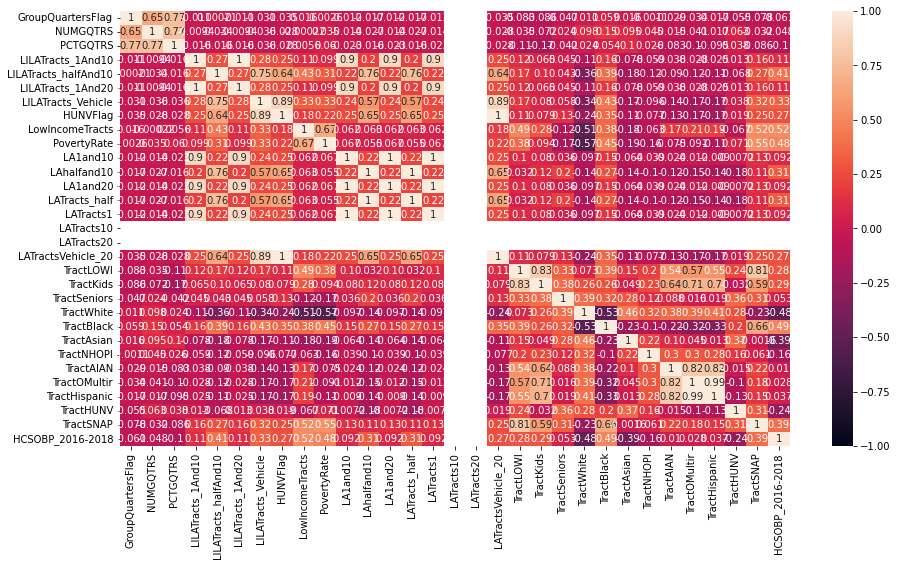

In [61]:
plt.figure(figsize=(15,8))
sns.heatmap(quick_fit_df.corr(), vmin=-1, vmax=1, annot=True);

### Save the Cleaned versions of tables used in this fit ###

In [63]:
food_obesity.to_csv('./data/food_obesity.csv', index=False)